# HSC Amp-to-Amp Offsets

## Useful links
* [LSKs GitHub Repo](https://github.com/leeskelvin/amp2amp)
* [Jira Ticket (DM-20303)](https://jira.lsstcorp.org/browse/DM-20303)
* [Dropbox paper: Background Exploration Aug 2018](https://paper.dropbox.com/doc/Background-Exploration-Aug-2018--ApTKzYDGr98X1Dl_UXBp5iGGAg-62Gc0Msel3yCa6VEtRVy7)
* [Eli's original analysis code](https://raw.githubusercontent.com/leeskelvin/amp2amp/master/ref/compute_and_plot_amp_offsets_pdr1_perpix4.py)
* [Eli's presentation: HSC Background Offsets: What's Up With That?](https://github.com/leeskelvin/amp2amp/blob/master/ref/hsc_background_offsets.pdf)
* [Boone et al. 2018](https://github.com/leeskelvin/amp2amp/blob/master/ref/Boone2018::2018PASP..130f4504B.pdf)

In [1]:
# output options
ccd = 43
outdir = 'singleccd-modeldelta'

# band selection [all|g|r|i|z|y]
band = 'all'
if band == 'all':
    bandname = 'grizy'
else:
    bandname = band

<h2>HSC CCD Arrangement</h2>
<h3 style="margin-top:10px; margin-bottom:25px;"><a href="https://subarutelescope.org/Observing/Instruments/HSC/ccd.html">https://subarutelescope.org/Observing/Instruments/HSC/ccd.html</a></h3>
<div style="width:700px; height:525px;"><img style="max-width:100%; max-height:100%;" src="ref/CCDPosition_20170212.png" alt="HSC CCDs"></div>

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import astropy.io.fits as fits
import esutil
import os.path
from astropy.time import Time

import lsst.afw.math as afwMath
import lsst.daf.persistence as dafPersist

In [3]:
# setup
if (not os.path.exists(outdir)):
    os.mkdir(outdir)

In [4]:
# butler
butlerVisit = dafPersist.Butler(
    '/datasets/hsc/repo/rerun/private/erykoff/fgcm_pdr1_run1wd/wide_deep2'
)
obsTable = butlerVisit.get(
    'fgcmVisitCatalog'
)
butler = dafPersist.Butler(
    '/datasets/hsc/repo/rerun/private/erykoff/hscproc/runIsrPDR1'
)

In [5]:
# define amps
camera = butler.get('camera')
det = camera[ccd]
amp1, amp2, amp3, amp4 = det.getAmplifiers()

In [6]:
# raw data bounding boxes
dbox1 = amp1.getRawDataBBox()
dbox2 = amp2.getRawDataBBox()
dbox3 = amp3.getRawDataBBox()
dbox4 = amp4.getRawDataBBox()

In [7]:
# horizontal overscan bounding boxes
obox1 = amp1.getRawHorizontalOverscanBBox()
obox2 = amp2.getRawHorizontalOverscanBBox()
obox3 = amp3.getRawHorizontalOverscanBBox()
obox4 = amp4.getRawHorizontalOverscanBBox()

In [8]:
# obsTable data
filtername = [d['filtername'] for d in np.asarray(obsTable)]
if band != 'all': 
    goodfilters = [i for i,s in enumerate(filtername) if band in s]
    filtername = np.asarray(filtername)[goodfilters]
else: 
    goodfilters = range(len(filtername))
visits = obsTable['visit'][goodfilters]
exptime = obsTable['exptime'][goodfilters]
skybackground = obsTable['skybackground'][goodfilters]
mjd = obsTable['mjd'][goodfilters]
t = Time(mjd, format="mjd")
obsdate = t.decimalyear
ufname,ufcount = np.unique(filtername, return_counts=True)
print('\033[1m')
print('Number of visits:', visits.size)
print('Number of visits by filter:', dict(zip(ufname,ufcount)))
print('Number of pixel rows:', dbox1.getHeight())
print('Exposure time range:', '[', "%.0f" % np.min(exptime), ':', "%.0f" % np.max(exptime), ']')
print('Sky background range:', '[', "%.2f" % np.min(skybackground), ':', "%.2f" % np.max(skybackground), ']')
print('Date of Obs. range:', '[', "%.2f" % np.min(obsdate), ':', "%.2f" % np.max(obsdate), ']')
print('\033[0m')


Number of visits: 5190
Number of visits by filter: {'g': 1030, 'i': 1041, 'r': 925, 'y': 1032, 'z': 1162}
Number of pixel rows: 4176
Exposure time range: [ 30 : 270 ]
Sky background range: [ 56.01 : 14375.22 ]
Date of Obs. range: [ 2014.23 : 2015.87 ]



In [16]:
# catalogue, set up a numpy array, one entry for each visit, containing named fields
cat = np.zeros(visits.size, dtype=[('amp1b', 'i4', (dbox1.getHeight(), 5)),
                                   ('amp2a', 'i4', (dbox2.getHeight(), 5)),
                                   ('amp3b', 'i4', (dbox3.getHeight(), 5)),
                                   ('amp4a', 'i4', (dbox4.getHeight(), 5)),
                                   ('overscan1', 'i4', (obox1.getHeight(), 2)),
                                   ('overscan2', 'i4', (obox2.getHeight(), 2)),
                                   ('overscan3', 'i4', (obox3.getHeight(), 2)),
                                   ('overscan4', 'i4', (obox4.getHeight(), 2)),
                                   ('modeldelta1', 'i4', (obox1.getHeight(), 1)),
                                   ('modeldelta2', 'i4', (obox2.getHeight(), 1)),
                                   ('modeldelta3', 'i4', (obox3.getHeight(), 1)),
                                   ('modeldelta4', 'i4', (obox4.getHeight(), 1)),
                                   ('visit', 'i4'),
                                   ('filtername', 'U1'),
                                   ('exptime', 'float32'),
                                   ('skybackground', 'float32'),
                                   ('obsdate', 'float32')
                                  ])
cat['visit'][:] = visits
cat['filtername'][:] = filtername
cat['exptime'][:] = exptime
cat['skybackground'][:] = skybackground
cat['obsdate'][:] = obsdate

In [17]:
# create data catalogue, looping over each visit to read pixel data - apply delta model fix
fitsout = '%s/ccd%03d_%s_data.fits' % (outdir, ccd, bandname)

# test if catalogue already exists
if (not os.path.exists(fitsout)):
    
    print('\033[1mgenerating new catalogue\033[0m')
    
    # loop over each visit (index, value)
    #for i, v in enumerate(visits):
    for i, v in enumerate(visits[:101]):
    
        # counter
        if (i % 200) == 0:
            print('On %d of %d' % (i, visits.size))

        # try to use butler to get raw data
        try:
            raw = butler.get('raw', visit=int(visits[i]), ccd=ccd)
        except:
            continue

        # get image/mask/variance map for each data region (converted to int64)
        data1 = raw.maskedImage[dbox1].getArrays()[0].astype(np.int64)
        data2 = raw.maskedImage[dbox2].getArrays()[0].astype(np.int64)
        data3 = raw.maskedImage[dbox3].getArrays()[0].astype(np.int64)
        data4 = raw.maskedImage[dbox4].getArrays()[0].astype(np.int64)

        # get image/mask/variance map for each horizontal overscan region (converted to int64)
        overscan1 = raw.maskedImage[obox1].getArrays()[0].astype(np.int64)
        overscan2 = raw.maskedImage[obox2].getArrays()[0].astype(np.int64)
        overscan3 = raw.maskedImage[obox3].getArrays()[0].astype(np.int64)
        overscan4 = raw.maskedImage[obox4].getArrays()[0].astype(np.int64)

        # extract final/initial/final/initial 5 columns (immediately next to overscan regions) from raw data arrays
        cat['amp1b'][i, :] = data1[:, -5: ]
        cat['amp2a'][i, :] = data2[:, 0: 5]
        cat['amp3b'][i, :] = data3[:, -5: ]
        cat['amp4a'][i, :] = data4[:, 0: 5]
        
        # extract initial/final columns from overscan regions (0=closest to data, 1=farthest from data)
        cat['overscan1'][i, :, 0] = overscan1[:, 0]
        cat['overscan1'][i, :, 1] = overscan1[:, -1]
        cat['overscan2'][i, :, 0] = overscan2[:, -1]
        cat['overscan2'][i, :, 1] = overscan2[:, 0]
        cat['overscan3'][i, :, 0] = overscan3[:, 0]
        cat['overscan3'][i, :, 1] = overscan3[:, -1]
        cat['overscan4'][i, :, 0] = overscan4[:, -1]
        cat['overscan4'][i, :, 1] = overscan4[:, 0]
        
        # delta overscan corrections
        cat['modeldelta1'][i, :, 0] = np.median(cat['overscan1'][i, :, 0] - cat['overscan1'][i, :, 1])
        cat['modeldelta2'][i, :, 0] = np.median(cat['overscan2'][i, :, 0] - cat['overscan2'][i, :, 1])
        cat['modeldelta3'][i, :, 0] = np.median(cat['overscan3'][i, :, 0] - cat['overscan3'][i, :, 1])
        cat['modeldelta4'][i, :, 0] = np.median(cat['overscan4'][i, :, 0] - cat['overscan4'][i, :, 1])
        
        # apply corrections
        cat['overscan1'][i, :, 1] - cat['modeldelta1'][i, :, 0]
        cat['overscan2'][i, :, 1] - cat['modeldelta2'][i, :, 0]
        cat['overscan3'][i, :, 1] - cat['modeldelta3'][i, :, 0]
        cat['overscan4'][i, :, 1] - cat['modeldelta4'][i, :, 0]
        
    # write out to FITS file
    fits.writeto(fitsout, cat, overwrite=True)

else:
    
    # read in existing FITS catalogue
    print('\033[1mreading existing catalogue\033[0m')
    hdulist = fits.open(fitsout)
    hdu = hdulist[1]
    cat = hdu.data

print('\033[1m')
{print (name, typ) for name, typ in cat.dtype.fields.items()}
print('\ncatalogue ingested')
print('\033[0m')

generating new catalogue
On 0 of 5190

amp1b (dtype(('<i4', (4176, 5))), 0)
amp2a (dtype(('<i4', (4176, 5))), 83520)
amp3b (dtype(('<i4', (4176, 5))), 167040)
amp4a (dtype(('<i4', (4176, 5))), 250560)
overscan1 (dtype(('<i4', (4176, 2))), 334080)
overscan2 (dtype(('<i4', (4176, 2))), 367488)
overscan3 (dtype(('<i4', (4176, 2))), 400896)
overscan4 (dtype(('<i4', (4176, 2))), 434304)
modeldelta1 (dtype(('<i4', (4176, 1))), 467712)
modeldelta2 (dtype(('<i4', (4176, 1))), 484416)
modeldelta3 (dtype(('<i4', (4176, 1))), 501120)
modeldelta4 (dtype(('<i4', (4176, 1))), 517824)
visit (dtype('int32'), 534528)
filtername (dtype('<U1'), 534532)
exptime (dtype('float32'), 534536)
skybackground (dtype('float32'), 534540)
obsdate (dtype('float32'), 534544)

catalogue ingested



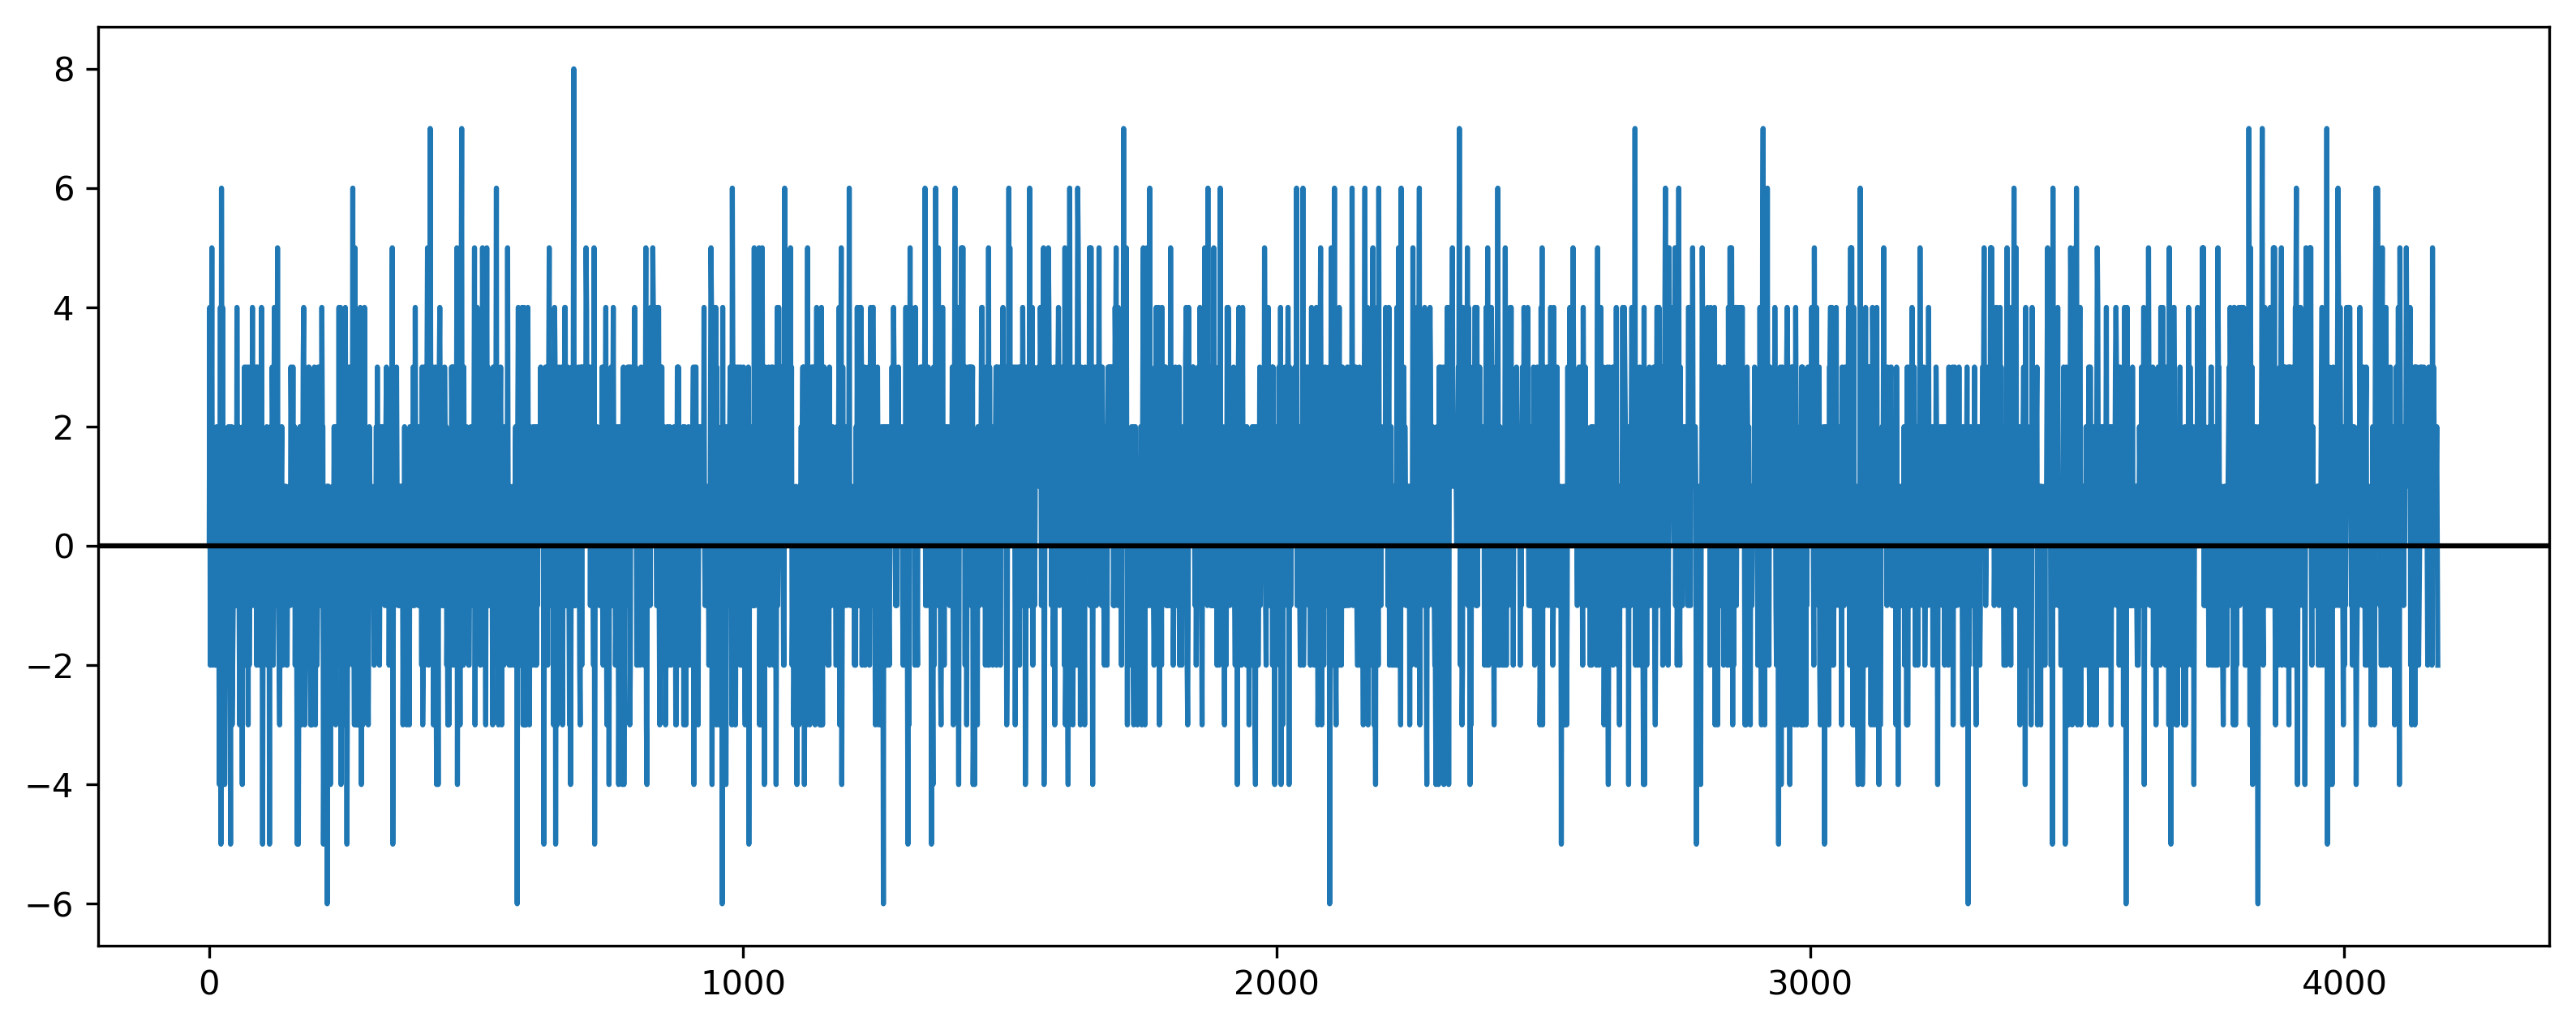

In [12]:
doverscan = overscan1[:,-1]-overscan1[:,0]
fig, axs = plt.subplots(1, sharex=True, sharey=True, figsize=(13,5), dpi=300)
plt.plot(overscan1[:,-1]-overscan1[:,0])
plt.axhline(y=0, color='black')
plt.show()

On 0 of 80
On 10 of 80
On 20 of 80
On 30 of 80
On 40 of 80
On 50 of 80
On 60 of 80
On 70 of 80


images constructed, all done!



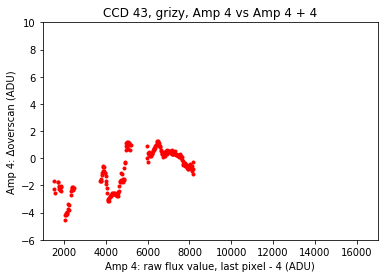

In [18]:
# make 80 plots...
# 4 amps on the y axis ...
# 4 amps on the x axis...
# +0, +1, +2, +3, +4 on the x axis...

# output names
fitsout = '%s/ccd%03d_%s_summary.fits' % (outdir, ccd, bandname)

# counter
counter = 0

# test if catalogue already exists
if (not os.path.exists(fitsout)):

    # loop over each amp
    for ampXAxis in [1, 2, 3, 4]:

        # amp labelling and geometry
        if ampXAxis == 1:
            ampXName = 'amp1b'
            lastPix = -1
        elif ampXAxis == 2:
            ampXName = 'amp2a'
            lastPix = 0
        elif ampXAxis == 3:
            ampXName = 'amp3b'
            lastPix = -1
        elif ampXAxis == 4:
            ampXName = 'amp4a'
            lastPix = 0

        # loop over each pixel column
        for offset in [0, 1, 2, 3, 4]:

            #  raw data: select all visits & rows, flatten entire column (cat: [ visits , rows , columns ])
            if lastPix == 0:
                ampFlat = cat[ampXName][:, :, offset].flatten()
            else:
                ampFlat = cat[ampXName][:, :, -1 - offset].flatten()

            # loop over each overscan region
            for ampOver in [1, 2, 3, 4]:

                # counter
                if (counter % 10) == 0:
                    print('On %d of %d' % (counter, 4*5*4))
                
                # overscan ID
                if ampOver == 1:
                    overname = 'overscan1'
                elif ampOver == 2:
                    overname = 'overscan2'
                elif ampOver == 3:
                    overname = 'overscan3'
                elif ampOver == 4:
                    overname = 'overscan4'

                # overscan data: select all visits & rows, flatten entire column (0/1 = closest/farthest from data)
                overFirst = cat[overname][:, :, 0].flatten()
                overLast = cat[overname][:, :, 1].flatten()

                # IDs of data elements with non-zero counts, non-sat. counts, and delta overscan abs. val. is <100
                clean, = np.where((ampFlat > 0) & (ampFlat < 30000) &
                                  (np.abs(overFirst - overLast) < 100)) # why is this 100?

                # return histogram/IDs of flattened & cleaned raw data
                h, rev = esutil.stat.histogram(ampFlat[clean], min=1000, max=30000, binsize=20, rev=True)

                # empty arrays
                values = np.zeros(h.size)
                deltas = np.zeros(h.size)

                # IDs of histogram bins with >= 50 counts
                ok, = np.where(h >= 50)

                # loop over each filled histogram bin
                for ind in ok:

                    # reverse lookup IDs
                    i1a = rev[rev[ind]: rev[ind + 1]]

                    # raw data values and overscan deltas
                    values[ind] = afwMath.makeStatistics(ampFlat[clean[i1a]], 
                                                         afwMath.MEDIAN).getValue()
                    deltas[ind] = afwMath.makeStatistics(overFirst[clean[i1a]] - overLast[clean[i1a]], 
                                                         afwMath.MEDIAN).getValue()

                # initialise output catalogue for first loop
                if counter == 0:
                    outCat = np.zeros(4 * 5 * 4, dtype=[('ampx', 'i4'),
                                                        ('ampy', 'i4'),
                                                        ('offset', 'i4'),
                                                        ('values', 'f4', h.size),
                                                        ('deltas', 'f4', h.size),
                                                        ('npix', 'i4', h.size)])

                # add data to output catalogue
                outCat['ampx'][counter] = ampXAxis # 
                outCat['ampy'][counter] = ampOver
                outCat['offset'][counter] = offset
                outCat['values'][counter, :] = values
                outCat['deltas'][counter, :] = deltas
                outCat['npix'][counter, ok] = h[ok]

                # IDs with filled bins (is this redundant, as ok is defined with h >= 50?)
                use, = np.where(outCat['npix'][counter, :] > 0)

                # generate plot
                plt.clf()
                plt.plot(outCat['values'][counter, use], outCat['deltas'][counter, use], 'r.')
                plt.ylim(-6, 10)
                plt.xlim(1000, 17000)
                plt.xlabel('Amp %d: raw flux value, last pixel - %d (ADU)' 
                           % (outCat['ampx'][counter], outCat['offset'][counter]))
                plt.ylabel('Amp %d: Δoverscan (ADU)' 
                           % (outCat['ampy'][counter]))
                plt.title('CCD %d, %s, Amp %d vs Amp %d + %d' 
                          % (ccd, bandname, outCat['ampy'][counter], outCat['ampx'][counter], outCat['offset'][counter]))
                plt.savefig('%s/ccd%03d_%s_amp%d_vs_amp%d+%d.png' 
                            % (outdir, ccd, bandname, outCat['ampy'][counter], outCat['ampx'][counter], 
                               outCat['offset'][counter]), 
                           dpi=300)

                # increment counter by 1
                counter += 1

    # write output to FITS catalogue
    fits.writeto(fitsout, outCat, overwrite=True)

print('\033[1m')
print('\nimages constructed, all done!')
print('\033[0m')